# Make predictions

## Load data and investigate

In [115]:
import csv
import sys
import ast

import pandas as pd
import numpy as np

# read in pickle file 
#prep =  "_preprocessed_" # 
prep = "_" #  
checkpoint = 'bert-base-uncased' 
#checkpoint = 'sentence-transformers_all-MiniLM-L6-v2'
cls_sep = "_without_CLS_SEP" # does not make sense for prep =  "_preprocessed_"
#cls_sep = ""

dataA = pd.read_pickle("dataA"+ prep + checkpoint + cls_sep + ".pkl")

f = open('results.txt', 'a')
f.write("\n" "=================================================")
f.write("\n" +"checkpoint = " + checkpoint)
if prep == "_preprocessed_":
    f.write("\n" +"preprocessed: True " + "noun, verb")
else: 
    f.write("\n" +"preprocessed: False")
if cls_sep == "_without_CLS_SEP":
    f.write("\n" + "CLS and SEP Tokens removed")
else:
    f.write("\n" + "without CLS and SEP Tokens removed")

f.write("\n" "-------------------------------------------------")
f.close()

# file to collect results "results.txt"


In [116]:
dataA["subset"].value_counts()

Train     60
Dev       15
Test      15
Sample    10
Name: subset, dtype: int64

In [117]:
dataA['sentence_type'].value_counts()

idiomatic    39
literal      31
Name: sentence_type, dtype: int64

In [118]:
# returns the dataframe sample and train (data items that have literal/idiomatic information given)
def only_train(dataA): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    return pd.concat([dataA[dataA["subset"] == "Sample"],dataA[dataA["subset"]== "Train"]])

In [119]:
# functions to display images

from PIL import Image
from IPython.display import display


fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

# Open the image file
def display_image(compound, fn):
    img = Image.open(fileDirectory + "\\" + compound + "\\" + fn)
    new_size = (150, 150)  # Width, Height
    img_resized = img.resize(new_size)  
    # Display the image
    display(img_resized)

# returns list of image names sorted from image1 to image5
def get_image_names(n,mydata):
    names = []
    for i in [1,2,3,4,5]:
         names.append(mydata['image' + str(i) + '_name'][n])
    return names


In [120]:
# print information of 1 item:

def print_item(n, mydata):
    # print  'sentence_type', 'sentence'
    compound = mydata['compound'][n]
    print(compound)
    print(mydata['sentence_type'][n])
    print(mydata['sentence'][n])
    print('---------------------------------------------------------------------')


    # for image_names in 'expected_order' print image_captions
    names  =  get_image_names(n,mydata)
    expected_order = mydata['expected_order'][n]
    print(expected_order)

    for image_name in expected_order:
        display_image(compound, image_name)
        # get index of image_name in names
        index = names.index(image_name) + 1
        print(mydata['image'+str(index)+'_caption'][n])
    

rocket science
idiomatic
This isn't rocket science: he talks about basic business skills like negotiation, time management and creativity.
---------------------------------------------------------------------
['89043407312.png', '66888109136.png', '83472329575.png', '05490541317.png', '61309592117.png']


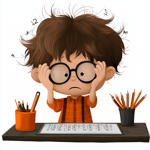

The image depicts a cartoon character sitting at a desk, looking frustrated or overwhelmed. The character has messy hair and is wearing glasses. On the desk in front of the character is a piece of paper with numbers written on it, suggesting some form of math or problem-solving activity. There are two pencil holders on the desk, one containing several pencils and the other containing a single pencil. The overall scene conveys a sense of stress or confusion, possibly related to the math problems on the paper.


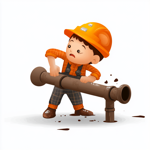

The image depicts a cartoon character dressed as a construction worker. The character is wearing an orange hard hat, an orange plaid shirt, and plaid overalls. They are holding a large brown pipe with both hands, seemingly trying to lift or move it. The character appears to be exerting effort, as indicated by their facial expression and the sweat on their forehead. There are small droplets of mud or dirt around the pipe, suggesting that the character might have been working in a muddy or dirty environment. The background is plain white, which helps to focus attention on the character and the pipe.


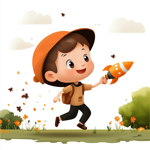

The image depicts a cheerful, cartoon-style illustration of a young boy running through a vibrant, outdoor scene. He is wearing an orange hat and a brown shirt with a pocket, black pants, and brown shoes. The boy is holding a small, orange rocket in his right hand, which appears to be in motion, suggesting he is launching it into the air. \n\nThe background features a clear sky with fluffy white clouds and a few butterflies flying around. The ground is covered with green grass and a variety of colorful flowers, including orange and yellow blooms. There are also some bushes or small trees on the right side of the image. The overall atmosphere of the image is playful and adventurous, capturing a moment of joy and imagination.


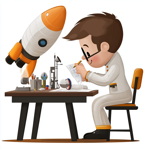

The image depicts a cartoon-style scene where a person is sitting at a desk, working on a project. The individual is wearing a white lab coat and glasses, suggesting they might be a scientist or engineer. On the desk, there are various tools and equipment, including a model rocket, a telescope, and other scientific instruments. The rocket appears to be in the process of being assembled or tested, with flames and smoke emanating from its base, indicating it is powered and ready for launch. The overall scene conveys a sense of creativity and innovation in a scientific or engineering context.


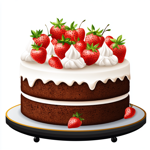

The image depicts a two-layered chocolate cake placed on a round, black cake stand with a gold rim. The cake has a smooth, white frosting border that runs along the top edge of each layer. The top layer is slightly larger than the bottom one, and both layers appear to be made of a moist, dense chocolate sponge.\n\nOn top of the cake, there is an abundance of fresh strawberries arranged in a somewhat scattered manner. The strawberries are bright red with green leaves attached to their stems. Some strawberries are positioned upright, while others are angled or lying flat, creating a natural and slightly messy appearance. The strawberries are generously spaced, allowing for a good amount of white frosting between them.\n\nThe cake stand itself is black with a gold rim, which adds a touch of elegance to the presentation. The stand is circular and appears to be sturdy, designed to hold the weight of the cake securely.\n\nIn summary, the image showcases a beautifully decorated chocolate cake

In [121]:
dataA_train = only_train(dataA)
print_item(12,dataA_train)

## Binary classification idiomatic/literal via cosine similarities

### Binary classification via cosine similarities using chatGPT data

In [122]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def compare(emb,emb0,emb1):
    sim0 = cosine_similarity(emb,emb0)
    sim1 = cosine_similarity(emb,emb1)
    if sim0 > sim1:
        return 0
    else:
        return 1

def binary2values(list,val0,val1):
    final = []
    for element in list:
        if element == 1:
            final.append(val1)
        else:
            final.append(val0)
    return final


In [123]:
#keep_columns = [c for c in dataA.columns if "embedding" not in c]
#dataA_pred = dataA[dataA.columns.intersection(keep_columns)]


In [124]:
compound_methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst']
methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst','firstCLS','lastCLS']


In [125]:
# only training data has sentence_type information
dataA_train = only_train(dataA)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

##### sentence embedding versus gpt sentence/meaning embedding

In [126]:
# systematic analysis sentence compared to gpt sentence embeddings
gpt_sents = ["sentence", "meaning"]

# write results to file results.txt
f = open('results.txt', 'a')
f.write("\n" +"Binary classification")
f.write("\n" +"sentence compared to gpt sentence embeddings")

print("sentence compared to gpt sentence embeddings")

for sent in gpt_sents:
    for m in methods:
        pred = dataA.apply(lambda x: compare(x["sentence_embedding_" + m],
                                         x["gpt_literal_" + sent + "_embedding_" + m], 
                                         x["gpt_idiomatic_" + sent + "_embedding_" + m]), axis=1)
        pred = binary2values(pred,"literal","idiomatic")
        dataA["pred_sentence_embedding_compared_to_gpt_" + sent + "_embedding_" +m  ] =pred

        dataA_train = only_train(dataA)
        pred = dataA_train["pred_sentence_embedding_compared_to_gpt_" + sent + "_embedding_" +m ]
        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),3))
        f.write("\n" +str(round(accuracy_score(y, pred),3))+  " -- " + sent + "_embedding_" + m)

#        print(classification_report(y, pred,zero_division=0))

f.write("\n" +"-----------------")
f.close()


sentence compared to gpt sentence embeddings
sentence_embedding_meanSecondToLast
0.829
sentence_embedding_meanLast4
0.814
sentence_embedding_meanLast
0.843
sentence_embedding_meanFirst
0.586
sentence_embedding_firstCLS
0.557
sentence_embedding_lastCLS
0.829
meaning_embedding_meanSecondToLast
0.743
meaning_embedding_meanLast4
0.729
meaning_embedding_meanLast
0.757
meaning_embedding_meanFirst
0.571
meaning_embedding_firstCLS
0.557
meaning_embedding_lastCLS
0.657


compound in sentence embedding versus compound in gpt sentence/meaning embedding

In [127]:
# systematic analysis compound embeddings
gpt_sents = ["sentence", "meaning"]

f = open('results.txt', 'a')
f.write("\n" +"compound in sentence compared to gpt compound in sentence embeddings")
print("compound in sentence compared to gpt compound in sentence embeddings")

for sent in gpt_sents:
    for m in compound_methods:
        pred = dataA.apply(lambda x: compare(x["compound_embedding_sentence_" + m],
                                         x["compound_embedding_gpt_literal_" + sent + "_" + m], 
                                         x["compound_embedding_gpt_idiomatic_" + sent + "_" + m]), axis=1)
        pred = binary2values(pred,"literal","idiomatic")
        dataA["pred_compound_embedding_sentence_compared_to_compound_embedding_gpt_" + sent + "_" +m  ] = pred

        dataA_train = only_train(dataA)
        pred = dataA_train["pred_compound_embedding_sentence_compared_to_compound_embedding_gpt_" + sent + "_" +m  ] 

        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),3))
        f.write("\n" + str(round(accuracy_score(y, pred),3)) + " -- "  +sent + "_embedding_" + m)

        
#        print(classification_report(y, pred,zero_division=0))

f.write("\n" +"-----------------")
f.close()



compound in sentence compared to gpt compound in sentence embeddings
sentence_embedding_meanSecondToLast
0.9
sentence_embedding_meanLast4
0.9
sentence_embedding_meanLast
0.857
sentence_embedding_meanFirst
0.471
meaning_embedding_meanSecondToLast
0.743
meaning_embedding_meanLast4
0.743
meaning_embedding_meanLast
0.671
meaning_embedding_meanFirst
0.543


Winner: compound in sentence embedding versus compound in gpt-sentence embedding with methods meanSecondToLast or meanLast4 

In [128]:
# systematic analysis compound embeddings of winning systems
gpt_sents = ["sentence"]

print("compound in sentence compared to gpt compound in sentence embeddings")
for sent in gpt_sents:
    for m in ["meanSecondToLast", "meanLast4"]:

        dataA_train = only_train(dataA)
        pred = dataA_train["pred_compound_embedding_sentence_compared_to_compound_embedding_gpt_" + sent + "_" +m  ] 

        # evaluate
        print(sent + "_embedding_" + m)
        y = dataA_train["sentence_type"]
        print(round(accuracy_score(y, pred),3))
        print(classification_report(y, pred,zero_division=0))


compound in sentence compared to gpt compound in sentence embeddings
sentence_embedding_meanSecondToLast
0.9
              precision    recall  f1-score   support

   idiomatic       0.92      0.90      0.91        39
     literal       0.88      0.90      0.89        31

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70

sentence_embedding_meanLast4
0.9
              precision    recall  f1-score   support

   idiomatic       0.92      0.90      0.91        39
     literal       0.88      0.90      0.89        31

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70



## Binary classification idiomatic/literal via machine learning model

#### sentence embeddings

Trained on sentence embeddings. No ChatGPT data is used

könnte noch in dataA geschrieben werden

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# mlp
from sklearn.neural_network import MLPClassifier
# knn
from sklearn.neighbors import KNeighborsClassifier


# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


dataA_train = only_train(dataA)


# write results to file results.txt
f = open('results.txt', 'a')
f.write("\n" +"ML models trained on sentence embeddings. No ChatGPT data is used")

print("Trained on sentence embeddings. No ChatGPT data is used")
print("===========================")
for method in methods: 
    # get data for training (subset column has value train or sample)

    X = dataA_train['sentence_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print(method)

    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
#    clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f.write("\n" + method + " accuracy idiomatic/literal: " + str(round(accuracy_score(y_test, y_pred),3)))
    print(round(accuracy_score(y_test, y_pred),3))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))

f.close()

Trained on sentence embeddings. No ChatGPT data is used
meanSecondToLast
0.714
meanLast4
0.714
meanLast
0.714
meanFirst
0.5
firstCLS
0.429
lastCLS
0.929


Be careful, results depend very much on random_state value in train-test-split

In [130]:

f = open('results.txt', 'a')
f.write("\n" +"results depend very much on random_state value in train-test-split")
f.write("\n" +"some results for varying random_state values:")


for rs in [0,1,2,3,5,10,13,42]: 
    # get data for training (subset column has value train or sample)
    method = "lastCLS"
    X = dataA_train['sentence_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

#    print("random_state=", rs)
    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
#    clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(round(accuracy_score(y_test, y_pred),3))
    f.write("\n" +"accuracy idiomatic/literal: " + str(round(accuracy_score(y_test, y_pred),3)))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))

f.close()


0.929


0.857
0.786
0.857
0.714
0.929
0.929
0.929


In [131]:
# dummy classifier most frequent
from sklearn.dummy import DummyClassifier

f = open('results.txt', 'a')
f.write("\n" +"dummy classifier most frequent")

# dummy classifier most frequent
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("dummy classifier most frequent")
f = open('results.txt', 'a')
f.write("\n dummy classifier most frequent - accuracy idiomatic/literal: " + str(round(accuracy_score(y_test, y_pred),3)))
print(round(accuracy_score(y_test, y_pred),3))


f.write("\n" +"-------------------")
f.close()


dummy classifier most frequent
0.429


#### compound embeddings

In [132]:

dataA_train = only_train(dataA)

f = open('results.txt', 'a')
f.write("\n" +"ML models trained on compound sentence embeddings. No ChatGPT data is used")

for method in compound_methods:
    X = dataA_train['compound_embedding_sentence_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print(method)
    # logistic regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f.write("\n" + method + " accuracy idiomatic/literal: " + str(round(accuracy_score(y_test, y_pred),3)))
    print(round(accuracy_score(y_test, y_pred),3))

    #classification report
#    print(classification_report(y_test, y_pred,zero_division=0))
f.write("\n" +"==============================================================")
f.close()


meanSecondToLast
0.857
meanLast4
0.786
meanLast
0.786
meanFirst
0.214


**Summary:** Best result for sentence embedding with method lastCLS 

## Ranking images by cosine similarity between image caption embeddings and sentence embeddings (no chatGPT data)

In [133]:
from scipy.stats import spearmanr

# evaluation functions for ranked orders
def top1accuracy(pred_rankings,expected_order):
    correct = 0
    for i in range(len(pred_rankings)):
        if pred_rankings[i][0] == expected_order[i][0]:
            correct += 1
    return round(correct/len(pred_rankings),3)


def spearman_correlation(pred_rankings,expected_order):
    corr = []
    for i in range(len(pred_rankings)):
        corr.append(spearmanr(pred_rankings[i],expected_order[i]).correlation)
    return round(np.mean(corr),3)


In [134]:
pred_rankings = []
type = 'sentence_embedding_' # 'compound_embedding_sentence_'
method = "meanLast4" # "lastCLS"
ranking_column = "pred_rankings_similarity_image_caption_to_" + type + "_" + method

pred_rankings = []
for i in range(len(dataA)):
    # compare cosine similarity of each picture_caption_embedding_meanLast4 and embedding_meanLast4
    embedding = dataA[type + method][i]
    image1_caption_embedding = dataA['image1_caption_embedding_' + method][i]
    image2_caption_embedding = dataA['image2_caption_embedding_' + method][i]
    image3_caption_embedding = dataA['image3_caption_embedding_' + method][i]
    image4_caption_embedding = dataA['image4_caption_embedding_' + method][i]
    image5_caption_embedding = dataA['image5_caption_embedding_' + method][i]
    similarity1 = cosine_similarity(embedding,image1_caption_embedding)
    similarity2 = cosine_similarity(embedding,image2_caption_embedding)
    similarity3 = cosine_similarity(embedding,image3_caption_embedding)
    similarity4 = cosine_similarity(embedding,image4_caption_embedding)
    similarity5 = cosine_similarity(embedding,image5_caption_embedding)
    # sort the similarities
    similarities = [similarity1,similarity2,similarity3,similarity4,similarity5]
    # sort and give indices
    idx = np.argsort(similarities)
    # reverse the indices
    idx = idx[::-1]
    pred_rankings.append(idx)
dataA[ranking_column] = pred_rankings

#  replace rank by according image name
for i in range(len(dataA)):
    idxs = pred_rankings[i]
    picture_names = get_image_names(i,dataA)
    # sort picture_names according to idxs
    picture_names = [picture_names[i] for i in idxs]
    dataA[ranking_column][i] = picture_names    

# evaluate
dataA_train = only_train(dataA)

f = open('results.txt', 'a')
f.write("\n" +"Predict Rankings")
f.write("\n" +"Method: compare image captions with sentence, order from most to least similar")
f.write("\n" +"column: " + ranking_column)
print("compare image captions with sentence")

print("top1 accuracy")
f.write("\n" +"top1 accuracy")
print(top1accuracy(dataA_train[ranking_column],dataA_train['expected_order']))
f.write("\n" +str(top1accuracy(dataA_train[ranking_column],dataA_train['expected_order'])))

print("spearman rank correlation")
f.write("\n" +"spearman rank correlation")
print(spearman_correlation(dataA_train[ranking_column],dataA_train['expected_order']))
f.write("\n" +str(spearman_correlation(dataA_train[ranking_column],dataA_train['expected_order'])))

f.write("\n" +"--------------------")
f.close()

compare image captions with sentence
top1 accuracy
0.343
spearman rank correlation
0.124


## Image ranking prediction via multi-step procedure

Procedure:
 1. decide on sentence: literal or idiomatic
 2. group 5 images into two pairs of very similar captions and one unrelated one
 2. decide which caption pair is the literal and which the idiomatic
 2. depending on decision 1 order the images.

### use gpt sentence/meaning (compound) embeddings to classify image captions 

Ziel: sortiere die 5 Bilder wie folgt
1: literal, 2: ähnlich wie literal, 3: ähnlich wie idiomatic, 4: idiomatic, 5: unrelated 

In [135]:
sim_to_literal = []
sim_to_idiomatic = []
m = "meanLast4"

n = 30


#emb_lit = dataA["gpt_literal_sentence_embedding_" +m][n]
#emb_id = dataA["gpt_idiomatic_sentence_embedding_" +m][n]

emb_lit = dataA["gpt_literal_meaning_embedding_" +m][n]
emb_id = dataA["gpt_idiomatic_meaning_embedding_" +m][n]

#emb_lit = dataA["compound_embedding_gpt_literal_meaning_" +m][n]
#emb_id = dataA["compound_embedding_gpt_idiomatic_meaning_" +m][n]


for i in [1,2,3,4,5]:
    emb_image = dataA["image" + str(i) + "_caption_embedding_" + m][n]
    sim_to_literal.append(cosine_similarity(emb_lit,emb_image))
    sim_to_idiomatic.append(cosine_similarity(emb_id,emb_image))

idx_lit = np.argsort(sim_to_literal )
idx_id = np.argsort(sim_to_idiomatic )
# reverse the indices
idx_lit = idx_lit[::-1].tolist() # list of indices of images from most similar to literal to least
idx_id = idx_id[::-1].tolist() # list of indices of images from most similar to idiomatic to least


name_list = get_image_names(n,dataA)

name_list_lit = [name_list[j] for j in idx_lit]
name_list_id = [name_list[j] for j in idx_id]



smoking gun
literal
Smoking gun is a literal term for a gun that is still smoking after being fired.


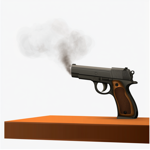

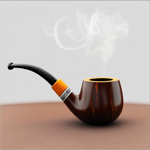

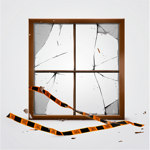

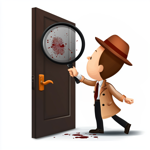

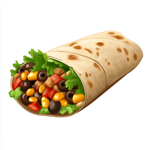

idiomatic
Smoking gun is a metaphor for clear and undeniable evidence of wrongdoing or guilt.


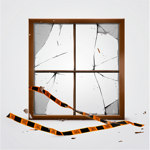

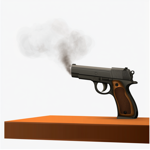

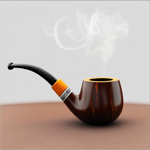

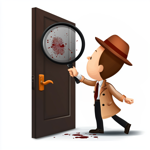

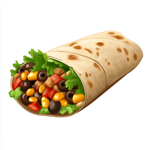

expected order idiomatic


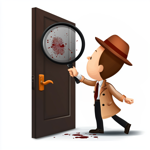

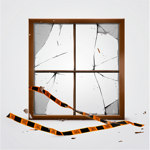

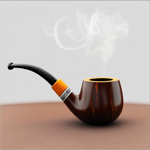

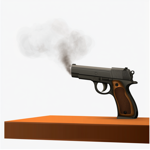

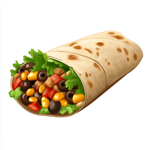

In [136]:
fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

compound = dataA["compound"][n]
print(compound)
print("literal")
print(dataA["gpt_literal_meaning"][n])
for fn in name_list_lit:
    display_image(compound,fn)

print("idiomatic")
print(dataA["gpt_idiomatic_meaning"][n])
for fn in name_list_id:
    display_image(compound,fn)


print("expected order", dataA["sentence_type"][n])
name_list_ex = dataA["expected_order"][n]
for fn in name_list_ex:
    display_image(compound,fn)


Example shows that sorting by literal/idiomatic is often contradictory

#### step1: find most similar pair and second most similar pair of image captions:

In [137]:
# compare all pictures to each other and get 2 pairs of most similar ones.

m="meanLast4"
#m= "lastCLS"
n= 30

dataA["pairs"] = [None for p in range(len(dataA))]

for n in range(len(dataA)):
    sim = np.zeros((5,5)) # obere Dreiecksmatrix der paarweisen Ähnlichkeiten der image captions

    for i in range(5):
        emb_image_i = dataA["image" + str(i+1) + "_caption_embedding_" + m][n]
        for j in range(i+1,5):
            emb_image_j = dataA["image" + str(j+1) + "_caption_embedding_" + m][n]
            sim[i,j] = cosine_similarity(emb_image_i,emb_image_j)
        
    name_list = get_image_names(n,dataA)
    compound = dataA["compound"][n]
    
    u,v = np.unravel_index(np.argmax(sim),sim.shape) # indices of pair with highest similarity 
    simN = np.delete(sim,[u],0) # delete row of max pair
    simN = np.delete(simN,[v],1) # delete column of max pair
    max = np.max(simN)
    b = np.where(sim == max)
    u1 = b[0][0] # u1,v1 indices of pair with second highest similarity 
    v1 = b[1][0]
    
    unrel = list(set([0,1,2,3,4])-set([u,v,u1,v1]))[0]
    dataA["pairs"][n] = [[(v+1,u+1),(v1+1,u1+1),unrel+1],[(name_list[v],name_list[u]),(name_list[v1],name_list[u1]),name_list[unrel]]]
    
f = open('results.txt', 'a')
f.write("\n" +"Multistep ranking method")
f.write("\n" +"step1: find most similar pair and second most similar pair of image captions")
f.write("\n" +"method for image caption embedding: " + m)
f.close()

     


#### step 2: decide which pair is literal and which is idiomatic

In [138]:
dataA["literal_image"] = [None for p in range(len(dataA))]
dataA["idiomatic_image"] = [None for p in range(len(dataA))]
dataA["unrelated_image"] = [None for p in range(len(dataA))]

m = "meanLast4"
for n in range(len(dataA)):
    [(u1,v1),(u2,v2),un] = dataA["pairs"][n][0]
    # compare to gpt_sentence_embedding
    sent = "image"# "sentence" #  "meaning" #
    comp_lit = dataA["gpt_literal_" + sent + "_embedding_" + m][n]
    comp_id = dataA["gpt_idiomatic_" + sent + "_embedding_" + m][n]
    lit_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_lit)
    id_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_id)
    id_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_id)
    if np.max([lit_sim11,  lit_sim12]) > np.max([lit_sim21 , lit_sim22]): # compare pairs by maximal similarity to literal (alternative sum)
        if lit_sim11 > lit_sim12:
            dataA["literal_image"][n] = (u1,v1)
        else:
            dataA["literal_image"][n] = (v1,u1)
        if id_sim21 > id_sim22:
            dataA["idiomatic_image"][n] = (u2,v2)
        else: 
            dataA["idiomatic_image"][n] = (v2,u2)
    else:
        if lit_sim21 > lit_sim22:
            dataA["literal_image"][n] = (u2,v2)
        else:
            dataA["literal_image"][n] = (v2,u2)
        if id_sim11 > id_sim12:
            dataA["idiomatic_image"][n] = (u1,v1)
        else:
            dataA["idiomatic_image"][n] = (v1,u1)
    dataA["unrelated_image"][n] = un  


f = open('results.txt', 'a')
f.write("\n" +"step 2: decide which pair is literal and which is idiomatic")
f.write("\n" +"method for image caption embedding: " + m)
f.write("\n" +"compared to : gpt_" + sent + " embedded by " + m)
f.close()
            
    
    
    
     
                                 
                               

#### step 3: make ranking depending on predicted literal/idiomatic classification

In [139]:
dataA["pred_rankings_combined"] = [0 for p in range(len(dataA))]

pred_column = "pred_compound_embedding_sentence_compared_to_compound_embedding_gpt_sentence_meanSecondToLast"
for n in range(len(dataA)):
    if dataA[pred_column] [n] == "literal":
        pred_idx = [dataA["literal_image"][n][0],
                    dataA["literal_image"][n][1],
                    dataA["idiomatic_image"][n][1],
                    dataA["idiomatic_image"][n][0],
                    dataA["unrelated_image"][n]]
    else:
        pred_idx = [dataA["idiomatic_image"][n][0],
                    dataA["idiomatic_image"][n][1],
                    dataA["literal_image"][n][1],
                    dataA["literal_image"][n][0],
                    dataA["unrelated_image"][n]]
    names = get_image_names(n,dataA)
    preds = [names[i-1] for i in pred_idx]
    dataA["pred_rankings_combined"][n] = preds
    

f = open('results.txt', 'a')
f.write("\n" +"step 3: make ranking depending on predicted literal/idiomatic classification")
f.write("\n" +"method for literal/idiomatic classification: " + pred_column)
f.close()



C:\Users\Wiebke Petersen\AppData\Local\Temp\ipykernel_19376\1631703973.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataA["pred_rankings_combined"][n] = preds


In [140]:
# evaluate
dataA_train = only_train(dataA)

f = open('results.txt', 'a')
f.write("\n" +"Evaluation")

print("combined approach idiomaticity + image caption analysis")
print("top1 accuracy")
f.write("\n" +"top1 accuracy")
print(top1accuracy(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))
f.write("\n" +str(top1accuracy(dataA_train['pred_rankings_combined'],dataA_train['expected_order'])))

print("spearman rank correlation")
f.write("\n" +"spearman rank correlation")
print(spearman_correlation(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))
f.write("\n" +str(spearman_correlation(dataA_train['pred_rankings_combined'],dataA_train['expected_order'])))
f.close()


combined approach idiomaticity + image caption analysis
top1 accuracy
0.414
spearman rank correlation
0.193


In [141]:



def find_permutation(L1, L2):
    oneline = []
    for n in L1:
        # Look for n in L2.
        # Sage's one-line permutation format expects indices to start at 1, not 0,
        # so add 1 to all indices here.
        j = L2.index(n) + 1
        # If we've already found this instance, look in the rest of the list for another one.
        while j in oneline:
            j += L2[j:].index(n) + 1
        oneline.append(j)
    return oneline



In [142]:
dataA_train = only_train(dataA)

lit_acc = 0
id_acc = 0
un_acc = 0
for n in range(len(dataA_train)):
    [lit,id,un] = dataA_train["pairs"][n][0]
    order = dataA_train["expected_order"][n]
    names = get_image_names(n,dataA_train)
    order = find_permutation(names,order)
#    print(order)
    if order[4] == un:
        un_acc = un_acc + 1
    if dataA_train["sentence_type"][n] == "literal":
        order = [(order[0],order[1]),(order[3],order[2]),order[4]]
    else:
        order = [(order[3],order[2]),(order[1],order[0]),order[4]]
    lit_acc = lit_acc + 1 - len(list(set(lit)-set(order[0])))/2 
    id_acc = id_acc + 1 - len(list(set(id)-set(order[1])))/2 
f = open('results.txt', 'a')
print("accuracy on unrelated: ", un_acc/len(dataA_train))
f.write("\n" + "accuracy on unrelated image: " +  str(round(un_acc/len(dataA_train),3)))
print("accuracy on literal: ", lit_acc/len(dataA_train))
f.write("\n" +"accuracy on literal images: " +  str(round(lit_acc/len(dataA_train),3)))
print("accuracy on idiomatic: ", id_acc/len(dataA_train))
f.write("\n" +"accuracy on idiomatic images: " + str(round(id_acc/len(dataA_train),3)))
print("accuracy on idiomatic/literal: " + str(accuracy_score(dataA_train[pred_column], dataA_train["sentence_type"])))
f.write("\n" + "accuracy on idiomatic/literal sentence: " + str(round(accuracy_score(dataA_train[pred_column], dataA_train["sentence_type"]),3)))
f.write("\n ======================================================= \n")
f.close()




accuracy on unrelated:  0.2571428571428571
accuracy on literal:  0.40714285714285714
accuracy on idiomatic:  0.4357142857142857
accuracy on idiomatic/literal: 0.9


Vielleicht doch besser CLS und SEP behalten

Benutze gpt_image Sätze

Weitere multistep ranking method:
 - wähle bei similarity to idiomatic/literal 

ML mit PCA/UMAP?

finetuned BERT

step1: find most similar pair and second most similar pair of image captions
method for image caption embedding: meanLast4
step 2: decide which pair is literal and which is idiomatic
method for image caption embedding: meanLast4
compared to : gpt_meaning embedded by meanLast4
step 3: make ranking depending on predicted literal/idiomatic classification
method for literal/idiomatic classification: pred_compound_embedding_sentence_compared_to_compound_embedding_gpt_sentence_meanSecondToLast
Evaluation
top1 accuracy
0.443
spearman rank correlation
0.279
accuracy on unrelated image: 0.257
accuracy on literal images: 0.407
accuracy on idiomatic images: 0.436
accuracy on idiomatic/literal sentence: 0.9


### alternative combined ranking method

### Submission

In [143]:
# returns the dataframe of subset
def only_subset(dataA, subset): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    return dataA[dataA["subset"] == subset]

In [144]:
dataA["subset"].value_counts()

Train     60
Dev       15
Test      15
Sample    10
Name: subset, dtype: int64

In [145]:
import pandas as pd
submission_df = pd.DataFrame()
dataA_sub = only_subset(dataA,"Dev")
submission_df["compound"] = dataA_sub["compound"]
submission_df["expected_order"] = dataA_sub["pred_rankings_combined"]


In [146]:
submission_df.head()

,compound,expected_order
70,monkey business,"[56875274126.png, 61570020623.png, 33778559524..."
71,grass roots,"[29204334751.png, 24221318591.png, 50278959002..."
72,marching orders,"[06066676443.png, 13776626434.png, 47713768923..."
73,panda car,"[52866539701.png, 29615068658.png, 42283780809..."
74,bread and butter,"[29490290047.png, 96897123911.png, 47437883453..."


In [147]:
submission_df.to_csv("submission_EN.tsv", sep="\t", index=False)
print("File saved as submission_EN.tsv")

File saved as submission_EN.tsv
